# MSA 2024 Phase 2 - Part 2

In [536]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Contents:
1. Load and split preprocessed data
2. Choose an algorithm (linear regression)
3. Train and test a model
4. Evaluate the model 
5. Bonus
    1. Choose an algorithm (ARIMA)
    2. Determining p, d and q
    3. Fit the ARIMA model
    4. Forecast and Evaluate the Model
6. Summary

## 1. Load and split preprocessed data

In [537]:
# Load and describe the dataset

df = pd.read_csv("../0. Resources/datasets/X store sales/preprocessed_store_sales.csv", encoding='latin_1')
df["Order Date"] = pd.to_datetime(df["Order Date"])
df.head()

,Order Date,Sales,Year,Month
0,2014-01-07,76.73,2014,1
1,2014-01-10,51.94,2014,1
2,2014-01-11,9.94,2014,1
3,2014-01-13,879.94,2014,1
4,2014-01-14,61.96,2014,1


In [538]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  880 non-null    datetime64[ns]
 1   Sales       880 non-null    float64       
 2   Year        880 non-null    int64         
 3   Month       880 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 27.6 KB


From above, we can see the loaded preprocessed store sales dataset, it contains 4 columns:

1. Order Date, with date data type, illustrates the order date for every transaction
2. Sales, with float data type, illustrates the total sales in a day
3. Year, with int data type, illustrates the year for the transactions
4. Month, with int data type, illustrates the month for the transactions

The target of this notebook, is to train and evaluation a model to predict sales over time.

In [546]:
df = df.copy()

df['Time'] = np.arange(len(df.index))

#df.info()

In [547]:
# Split the preprocessed datasets into a training set and a test set
X, y = df.loc[:, ['Time']], df.loc[:, 'Sales']
#X, y = df[['Year', 'Month']], df['Sales']

# Create an 70-30 train-test split on the dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 616 rows
Test Set: 264 rows


## 2. Choose an algorithm

In [548]:
# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)
print (model)

LinearRegression()


Linear regression is to model the relationship between a dependent variable and one or more independent variable. In this case, model the relationship between sales and time. This can be done by fitting a linear equation, thus y = mx + c. m indicates the slope or the rate of change in the dependent for each unit change in the independent. c is the intercept, it can be calculated when the independent is 0. The goal is to use linear regression to predict the sales over time with least sum of the squared differences between the observed and predicted values.

## 3. Train and test a model

In [549]:
# Get predictions using the features of a test set
predictions = model.predict(X_test)


np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ' ,y_test[:10])

Predicted labels:  [679. 683. 580. 612. 732. 665. 769. 623. 693. 616.]
Actual labels   :  408      92.47
423     354.90
16       20.32
141     555.84
617    1002.84
354      29.22
766     418.30
185     182.39
462    2072.46
157     100.38
Name: Sales, dtype: float64


In [550]:
# Test a model using predictions and the targets of a test set
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 395668.96102676133
RMSE: 629.0222261786632
R2: 0.0023483220371544045


With the metric above, we can see that MSE and RMSE is relatively high, a lower MSE and RMSE suggests better fit of the model to the data.

R2 is 0.0023 means the model only explains 0.23% of the variability in the dependent variable. This indicates a poor fit, the independent variable, time, is not a good predictor to sales, other independent variable can be included for further investigations, such as quantity, discount and profit.

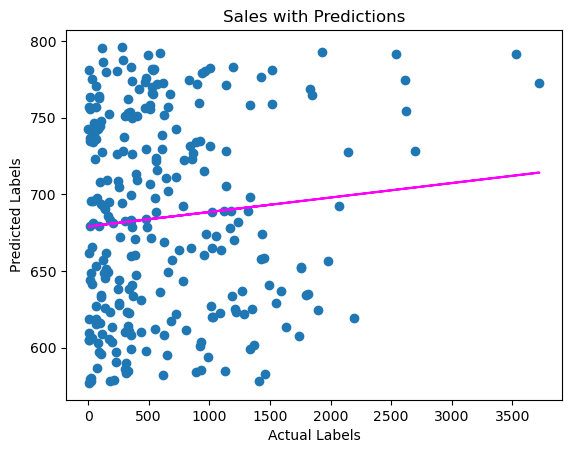

In [551]:
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Sales with Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

There is slightly diagonal trend, and there's a large difference between the ideal function represented by the line and the results. 

The closer the blue points are to the red line, the better the model's predictions. While there are some points close to the red line, the spread of the points indicates there are errors in the predictions, consistent with the MSE values we calculated.

Text(0, 0.5, 'Sales')

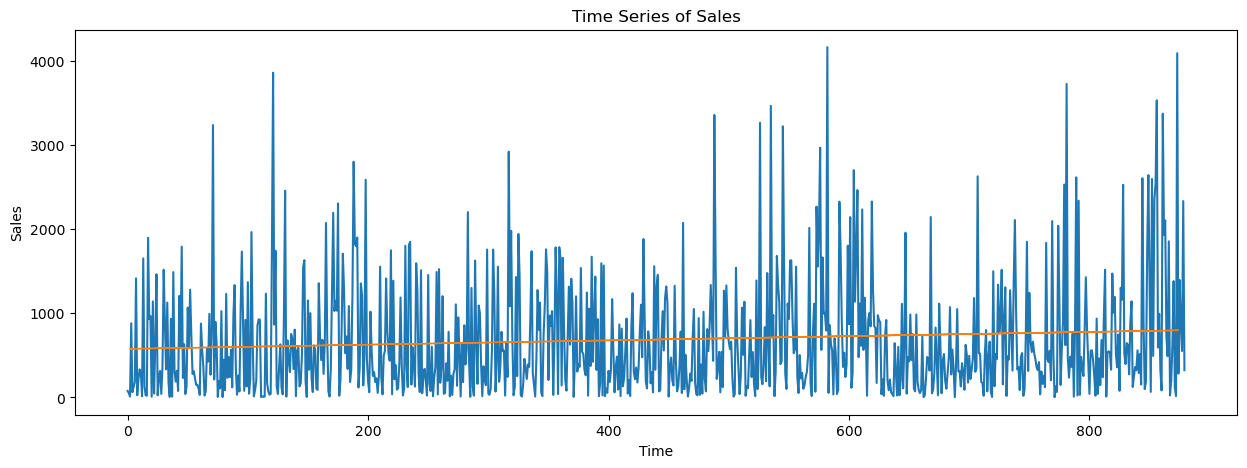

In [554]:
y_pred = pd.Series(predictions, index=y_test.index)

ax = y.plot(figsize= (15, 5))
ax = y_pred.plot(ax=ax, linewidth=1)
ax.set_title('Time Series of Sales')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

As we can see the linear fitted line only predict a trend of the sales over time, it does not give us the detail/ fluctuaction of the sales.

## 4. Evaluate the model 

In [525]:
# Write a function to calculate SMAPE
def smape(y_true, y_pred):
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Calculate the numerator (absolute difference)
    numerator = np.abs(y_true - y_pred)
    # Calculate the denominator (average of absolute actual and predicted values)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Calculate SMAPE
    smape_value = np.mean(numerator / denominator) * 100
    return smape_value

In [526]:
# Calculate SMAPE and MAPE
smape = smape(y_test,predictions)
print("SMAPE:", smape)

mape_value = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print("MAPE:", mape_value )


SMAPE: 83.16676607990199
MAPE: 633.267602842212


SMAPE represents the average of the absolute percentage errors between the predicted and actual values, adjusted for the scale of the data. The value of 83.17% indicates poor predictive performance, suggests significant error in the model's predictions.

MAPE represents the average absolute percentage difference between the predicted and actual values. The value 633.27% also indicates poor model performance. 

## 5. Bonus

#### Choose an algorithm (ARIMA), and plot ACF and PACF to determine the p, d, q parameters

ARIMA is a method that is flexible and robust, it is for time series forecasting. It stands for AutoRegressive Integrated Moving Average and consists of three main components:

1. AutoRegressive (AR), it regresses the variable on its own lagged (past) values. Order p,the number of lag observations included in the model.
2. Integrated (I), it differences the raw observations to make the time series stationary, so the mean and variance are constant over time. Order d, the number of times that the raw observations are differenced.
3. Moving Average (MA), it models the relationship between an observation and a residual error from a moving average model applied to lagged observations. Order q, size of the moving average window.

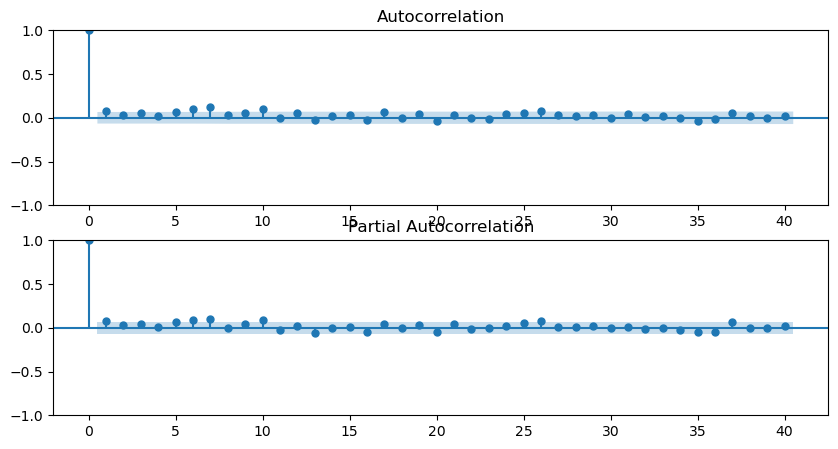

In [562]:
# Determine the appropriate order (p, d, q) for the ARIMA model using ACF and PACF plot

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
sm.graphics.tsa.plot_acf(df['Sales'], lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df['Sales'], lags=40, ax=ax[1])
plt.show()

#### Determining p and q
By looking at PACF and ACF plot, the first lag is significant, thus p = 1, q =1.

#### Determining d, checking stationarity

In [563]:
result = adfuller(df['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# p-value is less than 0.05, the series is stationary, so d = 0

ADF Statistic: -6.536699353474501
p-value: 9.56908979547012e-09


#### Fit the ARIMA Model

In [567]:
p = 1
q = 1
d = 0
# We typically don't need a training and testing split for ARIMA; instead, we'll use the data to fit the model and then forecast future values.
model = ARIMA(df['Sales'], order=(p, d, q)) 
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  880
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -6990.605
Date:                Sun, 04 Aug 2024   AIC                          13989.210
Time:                        18:05:50   BIC                          14008.330
Sample:                             0   HQIC                         13996.522
                                - 880                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        672.5437     68.555      9.810      0.000     538.178     806.909
ar.L1          0.9611      0.026     37.524      0.000       0.911       1.011
ma.L1         -0.9175      0.036    -25.364      0.0

#### Forecast and Evaluate the Model

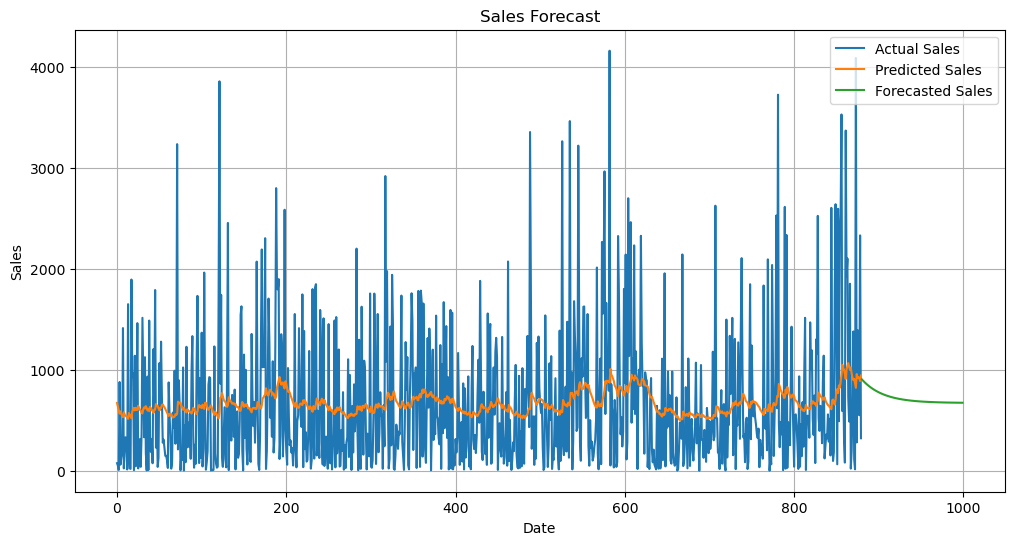

In [569]:
# Find the predicted and forecaseted sales compare to actual sales.
predictions = model_fit.predict()
forecasted = model_fit.forecast(steps=120)


plt.figure(figsize=(12, 6))
plt.plot(df['Sales'], label='Actual Sales')
plt.plot(predictions, label='Predicted Sales')
plt.plot(forecasted, label='Forecasted Sales')
plt.legend()
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

We can see that the predicted sales are following the same trend and also fluctuating over time, this is better compare to linear regression.

We can also see a forecasted sales of 120 days after the actual sales.

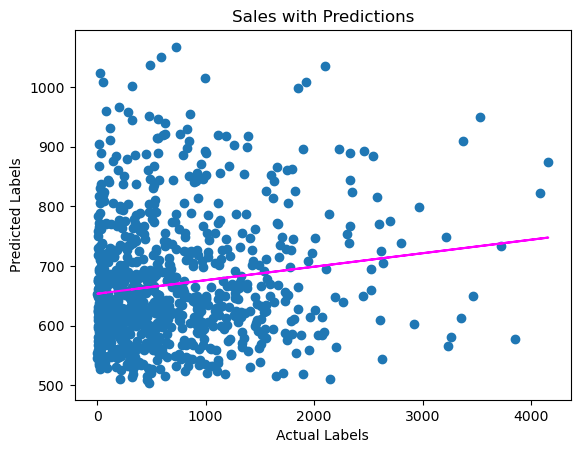

In [576]:
plt.scatter(y, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Sales with Predictions')
# overlay the regression line
z = np.polyfit(y, predictions, 1)
p = np.poly1d(z)
plt.plot(y,p(y), color='magenta')
plt.show()

There is slightly diagonal trend, and there's a difference between the ideal function represented by the line and the results. 

However, compare it to linear regression, there are more blue points closer to the red line.

In [579]:
# Test a model using predictions and actual sales
mse = mean_squared_error(y, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y, predictions)
print("R2:", r2)

mape_value = np.mean(np.abs((y - predictions) / y)) * 100
print("MAPE:", mape_value )

MSE: 465006.25077512977
RMSE: 681.9136681245873
R2: 0.02252118097970479
MAPE: 687.7232194112389


However, by comparing these metric, ARIMA has worse MSE, RMSE, MAPE, this can be because, the measurment is compared to actual sales, while linear regression's metric is comparing testing set.

R2 in this case, is 2.25%, which is better than linear regression.

## 6. Summary

After loading the preprocessed store sales data from part 1 in this notebook, we have choose two algorithms, and train and test them separately, then evaluate them in order to choose a fitter algorithm that is able to help us predict more accurate sales over time.

The first step is to Load and split preprocessed data, after loading the dataset, we have 4 columns, they are Order Date, Sales, Year and month. I have also created a new column called Time, which converts date into continuous number of days, which helps us better train our models.

Then I have split the data into train and test sets. There are 616 rows in the training Set and 264 rows in the test Set.

The first algorithm is linear regression. There are a few steps to evaluate it, and there are some findings:

1. Fit the dataset by using linear regression on the training set.
2. Get predictions using the features of a test set.
3. From this, we calculated some metric. We can see that MSE and RMSE is relatively high, a lower MSE and RMSE suggests better fit of the model to the data.
4. R2 is 0.0023 means the model only explains 0.23% of the variability in the dependent variable. This indicates a poor fit, the independent variable, time, is not a good predictor to sales, other independent variable can be included for further investigations, such as quantity, discount and profit.
5. SMAPE is 83.17% indicates poor predictive performance, suggests significant error in the model's predictions. MAPE is 633.27% also indicates poor model performance

6. There's a large difference between the ideal function represented by the line and the results. 
7. As we can see the linear fitted line only predict a trend of the sales over time, it does not give us the detail/ fluctuaction of the sales.
8. Since this is simple linear regression, only gives us a line, while our sales over time have seasonal patterns, so it may not be the best fit. 
9. Other variables can be included to see how the model will perform, such as quantity, discount, and profit.

The second algorithm is ARIMA. There are a few steps to evaluate it, and there are some findings:

1. Determine the appropriate order (p, d, q) for the ARIMA model using ACF and PACF plot, we found that order is (1,0,1).
2. We typically don't need a training and testing split for ARIMA; instead, we'll use the data to fit the model and then forecast future values. So we fit the whole dataset by using ARIMA.
3. Then we can find the predicted and forecasted sales with respect to actual sales.
4. We can see that the predicted sales are following the same trend and also fluctuating over time, this is better compare to linear regression. We can also see a forecasted sales of 120 days after the actual sales.
5. There's a difference between the ideal function represented by the line and the results. However, compare it to linear regression, there are more blue points closer to the red line.

6. However, by comparing the metric, ARIMA has worse MSE, RMSE, MAPE, this can be because, the measurment is compared to actual sales, while linear regression's metric is comparing testing set.
7. R2 in this case, is 2.25%, which is better than linear regression.
8. Further training can be done by choosing other algorithms, such as SARIMA.